### HW1： 

## **Part 1: Onion vs. Economist**

### Import Libraries

In [13]:
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Cleaning the texts
import re
import nltk
nltk.download('stopwords') # dictionary contains all stopping words
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 

# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mengh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preparation

In [3]:
econ_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/economist/'
onion_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/onion/'

def data_preparation(path, class_name):

    # Create Dictionary for File Name and Text
    file_name_and_text = {}
    
    if class_name == 'econ':
        sub_path_names = os.listdir(path)

        for sub_path in sub_path_names:
            file_names = os.listdir(path+sub_path)
            for file in file_names:
                if file.endswith(".txt"):
                    with open(path + sub_path + '/'+ file, "r") as target_file:
                         file_name_and_text[file] = target_file.read()
    else:
        file_names = os.listdir(path)

        for file in file_names:
            if file.endswith(".txt"):
                with open(path + file, "r") as target_file:
                     file_name_and_text[file] = target_file.read()

    file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
                 .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))
    file_data['class'] = class_name
    return file_data

def data_generate_label(df):
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])
    df = df.astype({'class': int})
    
    return df

econ_df = data_preparation(econ_path, 'econ')
onion_df = data_preparation(onion_path, 'onion')
article_df = pd.concat([econ_df, onion_df], ignore_index=True)

article_df = data_generate_label(article_df)
article_df.head()

,file_name,text,class
0,africa.1.txt,\n ...,0
1,africa.10.txt,\n ...,0
2,africa.11.txt,\n The Kurds say they still want more of it ...,0
3,africa.12.txt,\n A politician who paid the price for telli...,0
4,africa.13.txt,\n President Mwai Kibaki is loth to back dow...,0


### Data Cleaning 

In [4]:
def data_cleaning(article_df):
    corpus = [] # bag of words
    
    for index, row in article_df.iterrows():
        article = re.sub('[^a-zA-Z]', ' ', row['text']) # keep only letters
        article = article.lower() # lower case 
        article = article.split() # string to list 
        ps = PorterStemmer() # sstemmed

        article = [ps.stem(word) for word in article if not word in set(stopwords.words('english'))] # if not stopping word, reserve word 
        article = ' '.join(article) # list to string 
        corpus.append(article)
        
        if (index+1) % 50 == 0:
            print('{} articles cleaned...'.format(index+1))
    print('complete.') 
    return corpus

corpus = data_cleaning(article_df)

50 articles cleaned...
100 articles cleaned...
150 articles cleaned...
200 articles cleaned...
250 articles cleaned...
300 articles cleaned...
350 articles cleaned...
400 articles cleaned...
450 articles cleaned...
500 articles cleaned...
550 articles cleaned...
600 articles cleaned...
650 articles cleaned...
700 articles cleaned...
complete.


### Model Testing
+ Evaluate classifier using 10-fold cross validation and report overall prediction **accuracy**, **precision**, **recall** and **F1** of each class for the ***validataion set***.
+ Summarize errors using a confusion matrix for the ***test set***.

  Model  Accuracy  Precision    Recall  F1 Score
0    NB  0.989655   0.990265  0.989655  0.989787


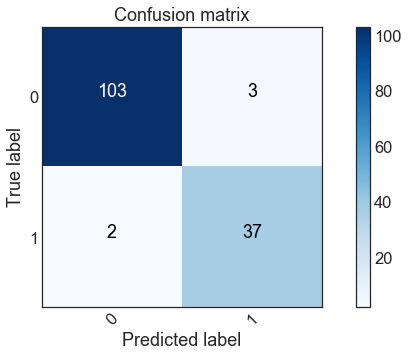

In [53]:
def nlp_model(corpus, article_df):
    cv = CountVectorizer(max_features = 11000)
    X = cv.fit_transform(corpus).toarray()
    y = article_df.loc[:, 'class'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average='weighted'), 
           'f1_score' : make_scorer(f1_score, average='weighted')}
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_validate(estimator=classifier, X=X_train, y=y_train, cv=kfold, scoring=scoring)
    kfold_performance = pd.DataFrame({'Model': 'NB', 'Accuracy': np.mean(results['test_accuracy']),
                                       'Precision': np.mean(results['test_precision']),
                                       'Recall': np.mean(results['test_recall']),
                                       'F1 Score': np.mean(results['test_f1_score'])}, index=[0])
    print(kfold_performance)
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title='Confusion matrix')


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-white')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
nlp_model(corpus, article_df)

## **Part 2: Economist Regions**

### Data Preparation

In [31]:
econ_path = 'C:/Users/mengh/Dropbox/FRE-7871-News-Analytics-and-Machine-Learning/HW1/economist/'

def econ_data_preparation(path):
    df = pd.DataFrame(columns=['file_name', 'text', 'class'])  
    region_names = os.listdir(path)

    for region_name in region_names:
        # Create Dictionary for File Name and Text
        file_name_and_text = {}
        file_names = os.listdir(path+region_name)
        for file in file_names:
            if file.endswith(".txt"):
                with open(path + region_name + '/'+ file, "r") as target_file:
                     file_name_and_text[file] = target_file.read()

        file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
                     .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))
        file_data['class'] = region_name    
        df =  pd.concat([df, file_data], ignore_index=True)
    
    return df, region_names

econ_df, region_names = econ_data_preparation(econ_path)
econ_df = data_generate_label(econ_df)
econ_df.head()

,file_name,text,class
0,africa.1.txt,\n ...,0
1,africa.10.txt,\n ...,0
2,africa.11.txt,\n The Kurds say they still want more of it ...,0
3,africa.12.txt,\n A politician who paid the price for telli...,0
4,africa.13.txt,\n President Mwai Kibaki is loth to back dow...,0


### Data Cleaning

In [32]:
corpus_econ = data_cleaning(econ_df)

50 articles cleaned...
100 articles cleaned...
150 articles cleaned...
200 articles cleaned...
250 articles cleaned...
300 articles cleaned...
350 articles cleaned...
400 articles cleaned...
450 articles cleaned...
500 articles cleaned...
complete.


  Model  Accuracy  Precision    Recall  F1 Score
0    NB  0.814563   0.849923  0.814563  0.811468


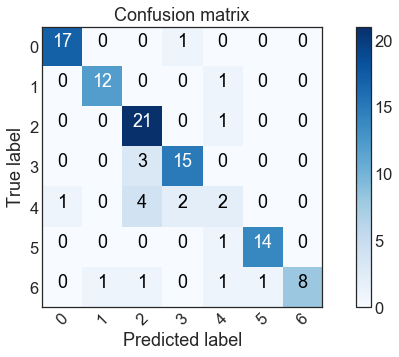

In [54]:
nlp_model(corpus_econ, econ_df)